# Optimal Interpolation (OI) / Gauss-Markov smoothing

From Kalnay, 2003 (Atmospheric Modeling, Data Assimilation and Predictability)

## Optimal Interpolation equation
$\renewcommand{\vec}[1]{\mathbf{#1}}$
[](http://twister.caps.ou.edu/OBAN2016/OI_partI.pdf)
[](http://twister.caps.ou.edu/OBAN2016/OI_partII.pdf)
[](http://twister.caps.ou.edu/OBAN2016/METR5303_Lecture14.pdf)
[](Kalman filter)
[](https://team.inria.fr/moise/files/2012/03/Nodet_Intro_DataAssimilation.pdf)
[](http://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html)
[](https://stackoverflow.com/questions/13901997/kalman-2d-filter-in-python)
$$ \vec{x}^a = \vec{x}^b + \vec{W} \left[\vec{y}^o - \vec{H}(\vec{x}^b)\right] = \vec{x}^b + \vec{W}\vec{d} $$

$\vec{x}^a$ - optimum analysis of a field of model variables, ie. $\vec{x}^a  = (T, S, u, v) $  
$\vec{x}^b$ - background field available at grid points  
$\vec{y}^0$ - set of observations available at irregularly spaced point with radius $\vec{r}_i$ from grid point  
$H$ - forward observational operator, converts background field into "observed first guesses"  
$\vec{d} $ - "innovation" or "observational increments" vector, defined as difference between the observation and the background mapped to the observational point via forward operator $\vec{H}$

$\vec{x}^a$,
$\vec{x}^b$ - vectors of length $n$, the number of grid points times the number of model variables  
$\vec{y}^0$,
$\vec{d}$ - vectors of length $p$, the number of observations

### Weight matrix

$$ \vec{W} = \vec{B}\vec{H}^T\left(\vec{R} + \vec{H}\vec{B}\vec{H}^T\right)^{-1} $$

$\vec{W}$ - weight matrix with shape ($n\times p$)  
$\vec{H}$ - linear operator matrix with shape ($p\times n$)  
$\vec{A}$ - analysis error covariance matrix with shape ($ n\times n$)  
$\vec{B}$ - background error covariance matrix with shape ($ n\times n$)  
$\vec{R}$ - observation error covariance matrix with shape ($ p\times p$)



### Error covariance matrices

analysis error and background error as vectors of length $n$

$$ \vec{\varepsilon}^a(x, y) = \vec{x}^a(x,y) - \vec{x}^t(x,y) $$
$$ \vec{\varepsilon}^b(x, y) = \vec{x}^b(x,y) - \vec{x}^t(x,y) $$

observational errors as vector of length $p$

$$ \vec{\varepsilon}^o_i = \vec{y}^o(\vec{r}_i) - \vec{y}^t(\vec{r_i}) $$

error covariance matrices for the analysis, background and observations

$$ \vec{A} = E\{\vec{\varepsilon}^a(\vec{\varepsilon}^a)^T\} $$
$$ \vec{B} = E\{\vec{\varepsilon}^b(\vec{\varepsilon}^b)^T\} $$
$$ \vec{R} = E\{\vec{\varepsilon}^o(\vec{\varepsilon}^o)^T\} $$

analysis covariance matrix

$$ \vec{A} = (\vec{I} - \vec{W}\vec{H})\vec{B}$$

$\vec{I}$ - identity matrix with shape ($ n\times n$)


### Linear observation operator

$$ \vec{H} $$

In [2]:
import numpy as np
from OceanPy.interpolation import polyfit2d

import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
# create some initial data points
x = np.array([0.95, -0.5, -0.5, 0.5, -1])
y = np.array([-0.5, 0.95, -0.5, 0.75, -1])
T_o = 3*x**2 + 2*y**3 + 2

# define grid of background field
nx, ny = 20, 20
xi, dx, = np.linspace(-1, 1, nx, retstep=True)
yi, dy = np.linspace(-1, 1, ny, retstep=True)
xx, yy = np.meshgrid(xi, yi)
xc, yc = xi[0] + (nx - 1) * dx / 2, yi[0] + (ny - 1) * dy / 2

# determine background field by fitting a linear polynomial
f = polyfit2d(x, y, T_o, order=1)
T_b = f(xx, yy)


In [4]:
# number of grid points (N) and number of observations (P)
N = nx * ny
P = len(T_o)

# background error covariance is constant for all b_ii
varian_b = np.var(T_b)

# define length scale in the Gaussian exponential function 
L=1/4

# BACKGROUND ERROR COVARIANCE MATRIX
# Gaussian function to model the correlation between analysis point i and analysis point j
# gamma_ij = np.exp(-(r_ij/L)**2)
# r_ij is the distance between i and j
# L length scale, in the ocean mesoscale processes have a length scale on the order of the radius of deformation

B = np.matrix(np.ones((N, N)))
for m in range(1, N):
    mj = int(m / nx)
    mi = m - mj * nx

    xm = xc + (mi - int(nx / 2)) * dx
    ym = yc + (mj - int(ny / 2)) * dy

    for l in range(0, m):
        lj = int(l / nx)
        li = l - lj * nx

        xl = xc + (li - int(nx / 2)) * dx
        yl = yc + (lj - int(ny / 2)) * dy

        dist2 = (xm - xl) ** 2 + (ym - yl) ** 2
        cov = np.exp(-dist2 / (2 * L ** 2))
        B[m, l] = cov
        B[l, m] = cov

# variance background field
for m in range(0, N):
    B[m, m] = varian_b

# OBSERVATION ERROR COVARIANCE MATRIX
varian_r = np.var(T_o)
R = np.identity(P)
R = varian_r * R

# FORWARD OPERATOR OR OBSERVATION OPERATOR MATRIX
H = np.matrix(np.zeros((P, N)))
for k in range(P):
    xo = int(nx / 2) + (x[k] - xc) / dx
    yo = int(ny / 2) + (y[k] - yc) / dy
    
    i, j = int(xo), int(yo)
    if 0 <= i <= nx - 1 and 0 <= j <= ny - 1:
        i = i - 1 if i == nx - 1 else i
        j = j - 1 if j == ny - 1 else j
        
        wx = xo - i
        wy = yo - j
        
        H[k, j * nx + i] = wx * (1 - wy)
        H[k, j * nx + i + 1] = (1 - wx) * (1 - wy)
        H[k, j * nx + nx + i] = wx * wy
        H[k, j * nx + nx + i + 1] = (1 - wx) * wy


# BACKGROUND FIELD VECTOR AT GRID POINTS
x_b = np.reshape(T_b, (N, 1))

# BACKGROUND FIELD VECTOR AT OBSERVATION POINTS
y_b = H * x_b

# OBSERVATION FIELD VECTOR AT OBSERVATION POINTS
y_o = np.matrix(T_o).T

# INNOVATION OR OBSERVATIONAL INCREMENTS VECTOR
d = y_o - y_b

# WEIGHT OR GAIN MATRIX
W = B * H.T * (R + H * B * H.T).I

# ANALYSIS FIELD VECTOR
x_a = x_b + W * d

# reshape analysis filed vector into grid array and make matrix an array
T_a = np.asarray(np.reshape(x_a, (nx, ny)))

(-1.1, 1.1)

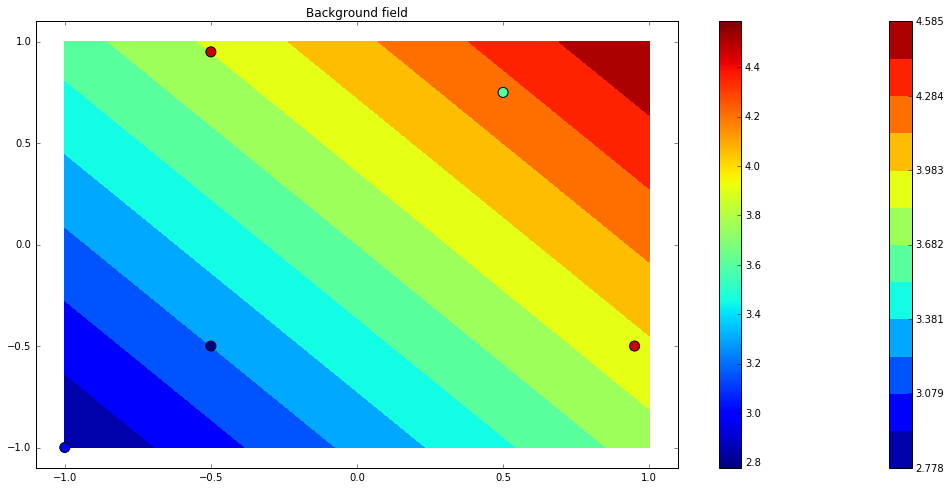

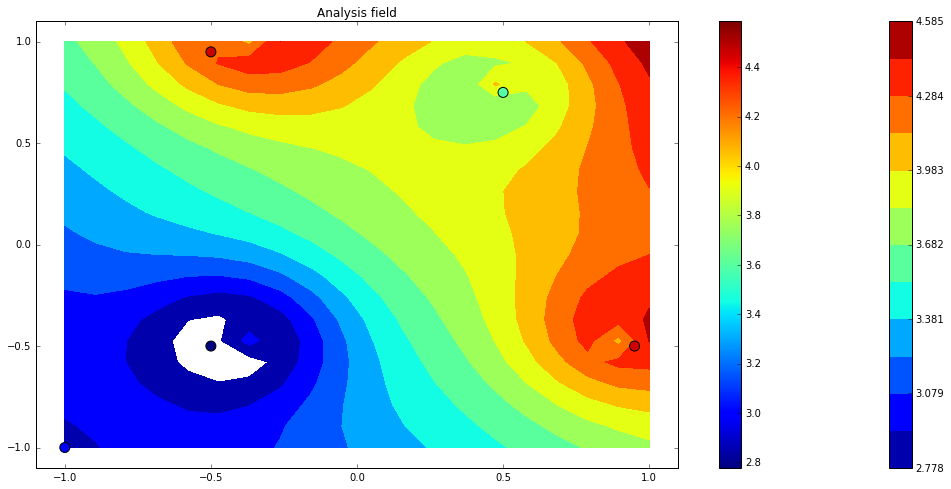

In [5]:
# plot background field
fig, ax = plt.subplots(figsize=(18, 8))
vmin, vmax = T_b.min(), T_b.max()
cf = ax.contourf(xx, yy, T_b, np.linspace(vmin, vmax, 13))
plt.colorbar(cf)
scat = ax.scatter(x, y, c=T_o, s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)
plt.title('Background field')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

fig, ax = plt.subplots(figsize=(18, 8))
cf = ax.contourf(xx, yy, np.asarray(T_a), np.linspace(vmin, vmax, 13))
plt.colorbar(cf)
scat = ax.scatter(x, y, c=T_o, s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)
plt.title('Analysis field')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

In [6]:
%run ../_setup.py

from netCDF4 import Dataset
from OceanPy.interpolation import OI

In [7]:
# load ctd data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

lon, lat = ctd['lon'][2:, 0], ctd['lat'][2:, 0]

# find indices of pressure levels
pressure_levels = {}
for ip, p in enumerate(ctd['p']):
    pressure_levels[p] = ip

# temperature at 500 dbar
T_o = ctd['t'][2:, pressure_levels[500]]

xx, yy, T_b, T_a = OI(lon, lat, T_o, L=(lon.max() - lon.min())/10)



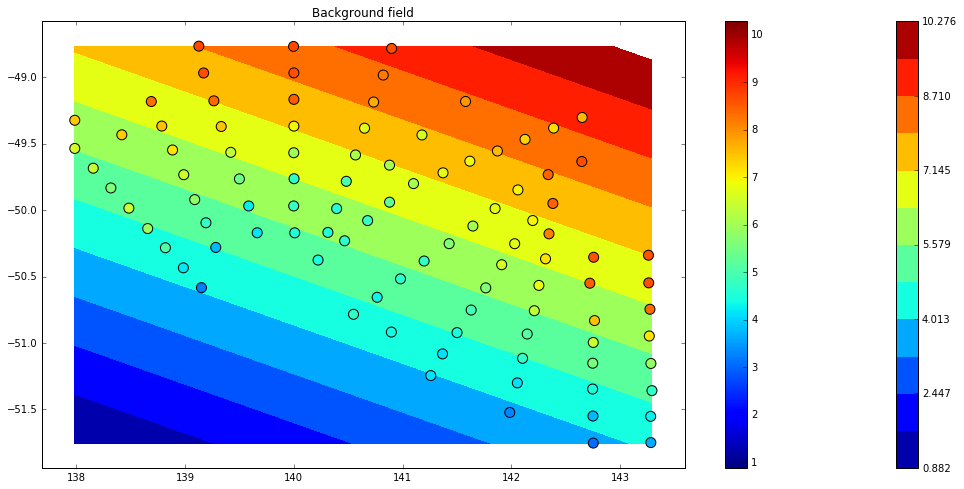

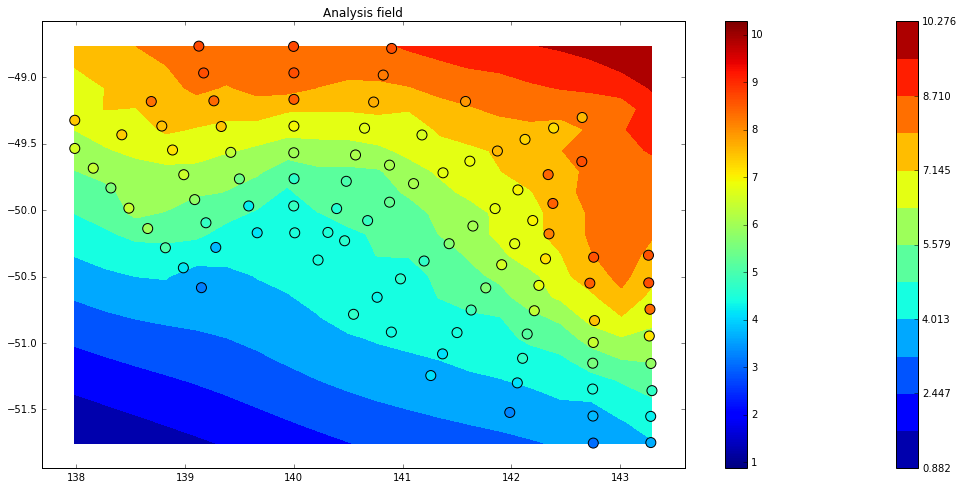

In [8]:
fig, ax = plt.subplots(figsize=(18, 8))
vmin, vmax = T_a.min(), T_a.max()
cf = ax.contourf(xx, yy, T_b, np.linspace(vmin, vmax, 13))
plt.colorbar(cf)
scat = plt.scatter(lon, lat, c=T_o, s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)
plt.title('Background field')

fig, ax = plt.subplots(figsize=(18, 8))
cf = ax.contourf(xx, yy, T_a, np.linspace(vmin, vmax, 13))
plt.colorbar(cf)
scat = plt.scatter(lon, lat, c=T_o, s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)
plt.title('Analysis field')

### For grid point $g$ influenced by $p$ observations

$$ x_g^a = x_g^b + \sum_{j=1}^{p}w_{gj}\delta y_j $$

$$ \delta y_j = y_o - y_b = y_o - H(x_b) $$

$$ b_{gk} = \sum_{j=1}^{p}w_{gj}(b_{jk} + r_{jk}) \quad \text{for} \quad k = 1,2, ..., p $$

$ b, r $ - background and observation error covariances, respectively  
$ b_{jk} $ - between observations  
$ b_{gk} $ - between grid point and observations

let b be modeled by $ b(r) = e^{-dr^2} $
